# SNR finder ANN model training

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from ler.utils import add_dict_values

In [47]:
# get data
from ler.utils import append_json, load_json
import numpy as np

# joint two dict
unlensed_params = load_json("snr_L1.json")
unlensed_params2 = load_json("joint_new_optsnr.json")
unlensed_params = add_dict_values(unlensed_params, unlensed_params2)
del unlensed_params2

# randomize the data
idx_shuffle = np.random.permutation(len(unlensed_params['L1']))
for key, value in unlensed_params.items():
    unlensed_params[key] = np.array(value)[idx_shuffle]

len(unlensed_params['L1'])

128675

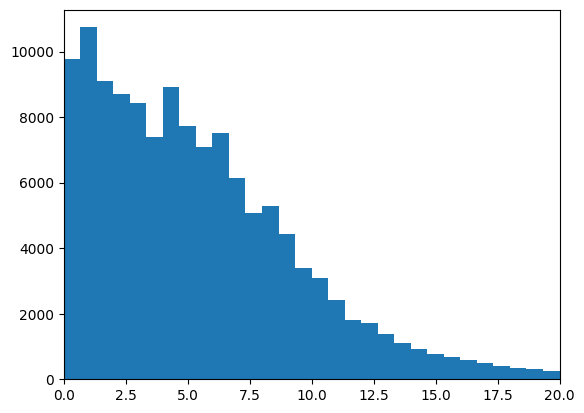

In [48]:
# visualize the data
import matplotlib.pyplot as plt
test = np.array(unlensed_params['L1'])
test = test[test<20]
plt.hist(test, bins=30)
plt.xlim(0,20)
plt.show()

In [49]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  None
ANN method is selected.
Please be patient while the interpolator is generated of partialscaledSNR for IMRPhenomD.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle


## Input-Output generator function

In [112]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    # phi_12 = np.array(params['phi_12'])[idx]
    # phi_jl = np.array(params['phi_jl'])[idx]

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)


    # input data
    # error=2.41%, 3.60%
    # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2]).T
    # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2]).T
    # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2]).T

    # error=2.72%, 3.32%
    # XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    # XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    # XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # error=2.79%, 3.28%
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

    # output data
    # get L1 snr for y train
    yL1 = params['L1'][idx]
    yH1 = params['H1'][idx]
    yV1 = params['V1'][idx]


    return(XL1, XH1, XV1, yL1, yH1, yV1)

In [79]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, XH1, XV1, yL1, yH1, yV1 = input_output(idx, unlensed_params)
np.shape(XL1)

(128675, 4)

## L1

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)

In [81]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [82]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [83]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [84]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [90]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
3619/3619 [==============================] - 2s 449us/step - loss: 0.6568 - accuracy: 6.9944e-04
Epoch 2/200
3619/3619 [==============================] - 2s 435us/step - loss: 0.6071 - accuracy: 6.9080e-04
Epoch 3/200
3619/3619 [==============================] - 2s 429us/step - loss: 0.6154 - accuracy: 6.9080e-04
Epoch 4/200
3619/3619 [==============================] - 2s 435us/step - loss: 0.6589 - accuracy: 7.7716e-04
Epoch 5/200
3619/3619 [==============================] - 2s 432us/step - loss: 0.6535 - accuracy: 7.3398e-04
Epoch 6/200
3619/3619 [==============================] - 2s 511us/step - loss: 0.5897 - accuracy: 7.6852e-04
Epoch 7/200
3619/3619 [==============================] - 2s 454us/step - loss: 0.6180 - accuracy: 6.8217e-04
Epoch 8/200
3619/3619 [==============================] - 2s 451us/step - loss: 0.6223 - accuracy: 7.7716e-04
Epoch 9/200
3619/3619 [==============================] - 2s 429us/step - loss: 0.6266 - accuracy: 8.1170e-04
Epoch 10/200
3619/3

In [91]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

403/403 [==============================] - 0s 391us/step
[[ 2.70200205  2.82277302]
 [ 0.38870335  0.31006868]
 [ 5.60412502  5.24579823]
 [ 0.23539734  0.15386778]
 [ 3.12788582  3.23441804]
 [ 4.76398802  4.6486933 ]
 [ 4.31961775  4.13931754]
 [ 4.16287708  4.17185805]
 [ 4.89632607  4.97591135]
 [ 6.34074068  6.24072374]
 [12.06006718 12.54865096]
 [ 5.41409206  5.88138031]
 [21.37667465 20.17674523]
 [ 4.85266161  5.19735151]
 [12.32242012 12.78739858]]


In [92]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>6) != (y_test>6))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 3.31%


12868
5655


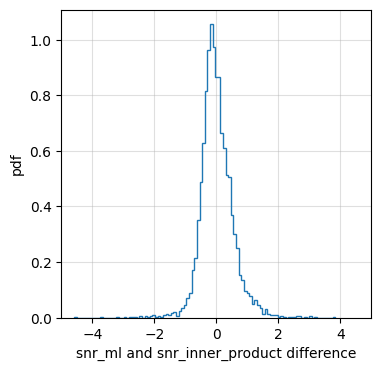

In [93]:
import matplotlib.pyplot as plt

y_pred = y_pred.flatten()
# y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [94]:
# Save the model to a file
ann.save('ann_modelL1.h5')

## H1

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [96]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [97]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [98]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
3619/3619 [==============================] - 2s 427us/step - loss: 10.2965 - accuracy: 1.1226e-04
Epoch 2/200
3619/3619 [==============================] - 2s 453us/step - loss: 3.4433 - accuracy: 2.6769e-04
Epoch 3/200
3619/3619 [==============================] - 2s 420us/step - loss: 2.3991 - accuracy: 3.5404e-04
Epoch 4/200
3619/3619 [==============================] - 2s 419us/step - loss: 1.9076 - accuracy: 2.9359e-04
Epoch 5/200
3619/3619 [==============================] - 2s 427us/step - loss: 1.6383 - accuracy: 3.4540e-04
Epoch 6/200
3619/3619 [==============================] - 2s 421us/step - loss: 1.4592 - accuracy: 3.0223e-04
Epoch 7/200
3619/3619 [==============================] - 2s 420us/step - loss: 1.3205 - accuracy: 3.0223e-04
Epoch 8/200
3619/3619 [==============================] - 1s 410us/step - loss: 1.2155 - accuracy: 3.3677e-04
Epoch 9/200
3619/3619 [==============================] - 2s 417us/step - loss: 1.1149 - accuracy: 3.1950e-04
Epoch 10/200
3619/

In [100]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

403/403 [==============================] - 0s 273us/step
[[ 2.69638872  2.88154786]
 [ 0.7322979   0.88632513]
 [ 5.51837778  5.20489792]
 [ 0.18054152  0.12729438]
 [ 3.71085691  3.93802885]
 [ 3.90713096  3.94485059]
 [ 3.76739287  3.73508224]
 [ 3.13078403  3.2402449 ]
 [ 5.09408379  5.24504292]
 [ 2.91837382  3.07340095]
 [13.01607895 13.49653498]
 [ 4.10761166  4.574675  ]
 [17.2495575  16.1630866 ]
 [ 9.32838631 10.19401786]
 [15.48104191 15.72194747]]


In [101]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.80%


In [102]:
# Save the model to a file
ann.save('ann_modelH1.h5')

## V1

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [104]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [105]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [106]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
3619/3619 [==============================] - 2s 425us/step - loss: 6.0651 - accuracy: 2.6769e-04
Epoch 2/200
3619/3619 [==============================] - 2s 452us/step - loss: 2.4633 - accuracy: 5.2674e-04
Epoch 3/200
3619/3619 [==============================] - 2s 539us/step - loss: 1.9188 - accuracy: 6.1309e-04
Epoch 4/200
3619/3619 [==============================] - 2s 444us/step - loss: 1.6844 - accuracy: 5.7855e-04
Epoch 5/200
3619/3619 [==============================] - 2s 426us/step - loss: 1.5139 - accuracy: 5.6991e-04
Epoch 6/200
3619/3619 [==============================] - 2s 450us/step - loss: 1.3816 - accuracy: 5.7855e-04
Epoch 7/200
3619/3619 [==============================] - 2s 444us/step - loss: 1.2944 - accuracy: 6.1309e-04
Epoch 8/200
3619/3619 [==============================] - 2s 470us/step - loss: 1.2242 - accuracy: 5.6128e-04
Epoch 9/200
3619/3619 [==============================] - 2s 431us/step - loss: 1.1776 - accuracy: 5.8718e-04
Epoch 10/200
3619/3

In [107]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:25])

403/403 [==============================] - 0s 286us/step
[[ 4.72483921  4.89011872]
 [ 0.51686001  0.58607411]
 [ 2.41460609  2.3015468 ]
 [ 0.37161541  0.33531481]
 [ 0.5280695   0.55868314]
 [ 2.36961079  2.32671789]
 [ 2.77364969  2.66532758]
 [ 1.93723869  2.00618009]
 [ 3.18798256  3.24378541]
 [ 5.53580332  5.29487968]
 [ 4.41453123  4.57756   ]
 [ 4.10081005  4.19438302]
 [ 8.1741991   7.69393088]
 [ 4.8905549   5.11534798]
 [10.4428978  10.75656564]]


In [108]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.23%


In [109]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [1]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

In [2]:
modelL1.save('test.h5')

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'][idx])
    mass_2 = np.array(params['mass_2'][idx])
    luminosity_distance = np.array(params['luminosity_distance'][idx])
    theta_jn = np.array(params['theta_jn'][idx])
    psi = np.array(params['psi'][idx])
    geocent_time = np.array(params['geocent_time'][idx])
    ra = np.array(params['ra'][idx])
    dec = np.array(params['dec'][idx])
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'][idx])
    a_2 = np.array(params['a_2'][idx])
    tilt_1 = np.array(params['tilt_1'][idx])
    tilt_2 = np.array(params['tilt_2'][idx])

    # effective spin
    chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, chi_eff]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, chi_eff]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, chi_eff]).T    

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(params['L1'][idx]**2 + params['H1'][idx]**2 + params['V1'][idx]**2)

    return(X,y)

## BBH

In [132]:
# generating new data
from ler.rates import LeR
ler = LeR(verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [142]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size)

unlensed params will be store in ./ler_data/unlensed_param.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|████████████████████████████████████████████████████████| 46375/46375 [01:10<00:00, 657.01it/s]


saving all unlensed_params in ./ler_data/unlensed_param.json...


In [143]:
X_, Y_ = input_output_net(np.arange(size), unlensed_params)

In [144]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)
    return(x_array,y)

In [145]:
_, snrANN =input_output_netANN(X_)

1563/1563 [==============================] - 0s 263us/step


50000
1440


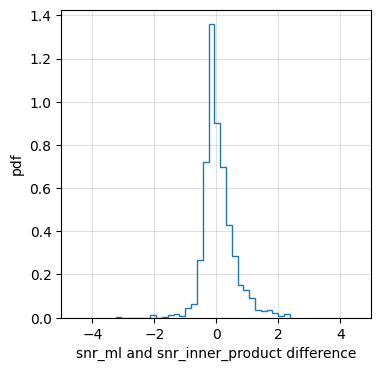

In [146]:
import matplotlib.pyplot as plt

y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<10)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=30, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [147]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 0.13%


In [148]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), (y_pred>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[49725    52]
 [   11   212]]


0.99874

In [149]:
#y_pred = (y_pred > 0.5)
idx = (y_test>4) & (y_pred<12)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[idx][10:25])

[[ 5.15850353  5.37186566]
 [ 5.92633295  4.90961826]
 [ 5.1957407   4.98641388]
 [ 4.82793283  6.81152986]
 [ 8.04278278  8.43912883]
 [ 3.9978323   4.20524464]
 [ 8.20208931  7.78337252]
 [ 4.30030012  4.13608912]
 [ 4.84817839  5.06148307]
 [ 5.4472084   4.87020935]
 [ 4.67050409  4.16562381]
 [ 5.00163841  5.57452582]
 [ 4.45889044  4.64078328]
 [ 4.47838306  4.61870046]
 [11.78038025 11.81251126]]


## BNS

In [5]:
# generating new data
from ler.rates import LeR
ler = LeR(npool=4, event_type = 'BNS', mtot_max=14, z_max = 2.0, verbose=False, snr_type='inner_product', waveform_approximant="IMRPhenomXPHM", spin_zero=False, spin_precession=True)

In [6]:
size = 50000
unlensed_params = ler.unlensed_cbc_statistics(size=size, output_jsonfile='unlensed_bns_ann_test.json')

unlensed params will be store in ./ler_data/unlensed_bns_ann_test.json
chosen batch size = 50000 with total size = 50000
There will be 1 batche(s)
Batch no. 1
sampling gw source params...
calculating snrs...
solving SNR with inner product


100%|█████████████████████████████████████████████████████████| 50000/50000 [10:22<00:00, 80.37it/s]


saving all unlensed_params in ./ler_data/unlensed_bns_ann_test.json...


In [10]:
from ler.utils import load_json
unlensed_params = load_json('ler_data/unlensed_bns_ann_test.json')

X_, Y_ = input_output_net(np.arange(size), unlensed_params)

NameError: name 'np' is not defined